##  CIFAR-10

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## ResNet 기본 블록 구성하기

In [3]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'stage' + str(stage+2) +'_'+ str(i+2) +'_'
        
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv1')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv3')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x


In [4]:
def conv_block(input_tensor, is_50, is_skip, channel, stage):
    conv_name_base = 'stage' + str(stage+2) + '_1_'
    bn_axis = 3
    if stage is 0:
        strides=(1,1)
    else:
        strides=(2,2)
        
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=strides, padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=strides,padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn3')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv3')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel*4, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn4')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), 
                           padding='same', name='stage1_1_conv1')(output)
    output = layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = layers.Activation('relu')(output)
    
    output = layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1))(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc100')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model
    
    

In [6]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
______________________________________________________________________________________________

In [7]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## 일반 네트워크(plain network) 만들기

In [8]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_102 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [9]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_147 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

## ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [10]:
BATCH_SIZE = 32
EPOCH = 20

### Input Normalization

In [27]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [28]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [37]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [38]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [39]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [40]:
ds_info.features["label"].names

['cat', 'dog']

In [41]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

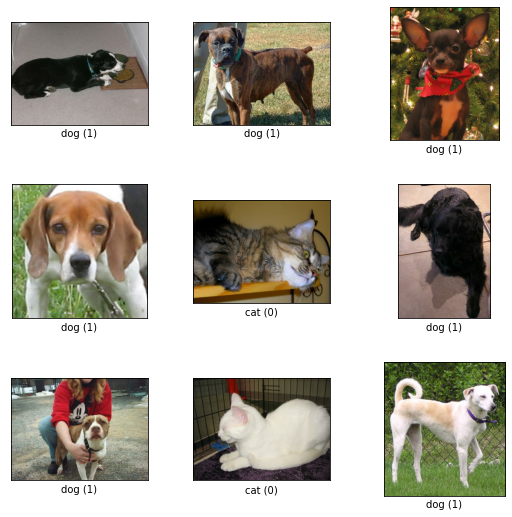

In [42]:
fig = tfds.show_examples(ds_train, ds_info)

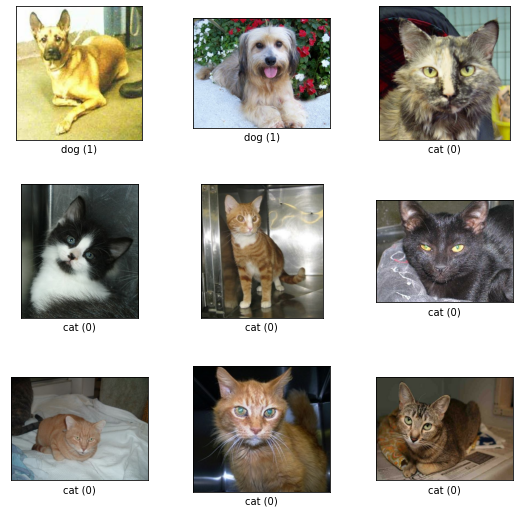

In [43]:
fig = tfds.show_examples(ds_test, ds_info)

In [44]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [46]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 105s 180ms/step - loss: 1.0779 - accuracy: 0.5662 - val_loss: 0.9451 - val_accuracy: 0.5825
Epoch 2/20
581/581 [==============================] - 122s 211ms/step - loss: 0.9168 - accuracy: 0.6240 - val_loss: 1.5771 - val_accuracy: 0.5330
Epoch 3/20
581/581 [==============================] - 97s 168ms/step - loss: 0.8074 - accuracy: 0.6666 - val_loss: 0.8342 - val_accuracy: 0.6089
Epoch 4/20
581/581 [==============================] - 98s 169ms/step - loss: 0.7415 - accuracy: 0.6946 - val_loss: 1.3137 - val_accuracy: 0.5722
Epoch 5/20
581/581 [==============================] - 97s 167ms/step - loss: 0.6594 - accuracy: 0.7348 - val_loss: 0.8530 - val_accuracy: 0.7171
Epoch 6/20
581/581 [==============================] - 97s 168ms/step - loss: 0.5889 - accuracy: 0.7701 - val_loss: 0.6792 - val_accuracy: 0.7291
Epoch 7/20
581/581 [==============================] - 96s 165ms/step - loss: 0.5147 - accuracy: 0.7988 - val_loss: 1.0324 - val_

In [49]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 87s 150ms/step - loss: 0.8417 - accuracy: 0.5072 - val_loss: 1.4218 - val_accuracy: 0.5073
Epoch 2/20
581/581 [==============================] - 88s 151ms/step - loss: 0.7888 - accuracy: 0.5214 - val_loss: 3.4185 - val_accuracy: 0.5009
Epoch 3/20
581/581 [==============================] - 87s 150ms/step - loss: 0.7808 - accuracy: 0.5212 - val_loss: 3.3936 - val_accuracy: 0.5004
Epoch 4/20
581/581 [==============================] - 87s 149ms/step - loss: 0.7727 - accuracy: 0.5268 - val_loss: 0.7099 - val_accuracy: 0.5532
Epoch 5/20
581/581 [==============================] - 86s 148ms/step - loss: 0.7622 - accuracy: 0.5310 - val_loss: 1.7397 - val_accuracy: 0.5248
Epoch 6/20
581/581 [==============================] - 87s 150ms/step - loss: 0.7514 - accuracy: 0.5310 - val_loss: 0.8944 - val_accuracy: 0.5287
Epoch 7/20
581/581 [==============================] - 87s 149ms/step - loss: 0.7397 - accuracy: 0.5321 - val_loss: 0.8945 - val_ac

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


In [59]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 93s 161ms/step - loss: 5.0909e-04 - accuracy: 0.9998 - val_loss: 1.3812 - val_accuracy: 0.7756
Epoch 2/20
581/581 [==============================] - 94s 161ms/step - loss: 7.4037e-04 - accuracy: 0.9998 - val_loss: 1.4716 - val_accuracy: 0.7548
Epoch 3/20
581/581 [==============================] - 93s 161ms/step - loss: 3.8686e-04 - accuracy: 0.9999 - val_loss: 1.3484 - val_accuracy: 0.7764
Epoch 4/20
581/581 [==============================] - 94s 162ms/step - loss: 4.3463e-04 - accuracy: 0.9999 - val_loss: 1.4738 - val_accuracy: 0.7754
Epoch 5/20
581/581 [==============================] - 92s 158ms/step - loss: 1.9815e-04 - accuracy: 1.0000 - val_loss: 1.4658 - val_accuracy: 0.7654
Epoch 6/20
581/581 [==============================] - 93s 160ms/step - loss: 5.0955e-04 - accuracy: 0.9998 - val_loss: 1.4192 - val_accuracy: 0.7774
Epoch 7/20
581/581 [==============================] - 94s 162ms/step - loss: 2.0055e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [1]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

NameError: name 'plt' is not defined

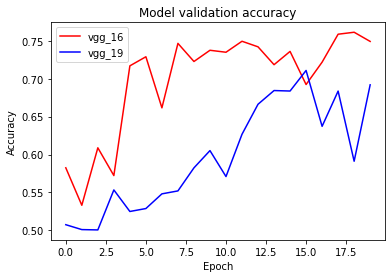

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_34 vs plain_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 1)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()